## Installation

In [ ]:
!pip install pyPLNmodels

### Getting Started with the PLN Model Package

We assume the data follows a Poisson log-normal (PLN) model:

$$ \mathbf{Y}_i \sim \mathcal{P}(\exp(\mathbf{Z}_i)), \quad \mathbf{Z}_i \sim \mathcal{N}(\mathbf{o}_i + \mathbf{B}^{\top} \mathbf{x}_i, \mathbf{\Sigma}). $$

The package aims to retrieve the latent variables $\mathbf{Z}$ from the observed counts and to infer the parameters $\mathbf{B}$ (`coef` in the package) and $\mathbf{\Sigma}$ (`covariance`), of size $d\times p $ and $p\times p$ respectively. Users can provide:

- A matrix of counts $\mathbf{Y}$ of size $n \times p$ (`endog`)
- A matrix of covariates $\mathbf{X}$ of size $n \times d$ (`exog`)
- An offsets matrix of size $n \times p$ (`offsets`)

Default values are available for the covariates and offsets if they are not provided, but the count matrix is required. 

In the following, we consider the `Pln` class implementing the PLN model as well as two variants of PLN: `PlnPCA` and `ZIPln`. We begin by analyzing a dataset without covariates, followed by an analysis that includes covariates.



### How to specify a model
Each model can be specified in two distinct manners:

* by formula (similar to R), where a data frame is passed and the formula is specified using the  ```from_formula``` initialization:

```model = Model.from_formula("endog ~ 1  + covariate_name ", data = data)# not run```

We rely to the [patsy](https://github.com/pydata/patsy) package for the formula parsing.

* by specifying the endog, exog, and offsets matrices directly:

```model = Model(endog = endog, exog = exog, offsets = offsets)# not run```


### Import the needed functions

In [1]:
from pyPLNmodels import load_scrna, Pln, PlnPCA, PlnPCAcollection, ZIPln, load_microcosm
import matplotlib.pyplot as plt

# Fitting models without covariates

### Load the data

We load a subsample of the [scMARK](https://www.biorxiv.org/content/10.1101/2021.12.08.471773v1) dataset of 400 cells (rows) and 100 genes (columns).

In [2]:
data  = load_scrna() 
counts = data["endog"]
labels = data["labels"]

Returning scRNA dataset of size (400, 100)


## `Pln`

This is the building-block of the models implemented in this package. It fits a Poisson lognormal model to the data:

In [3]:
pln = Pln(counts)
pln.fit()

Setting the offsets to zero.
Fitting a Pln model with full covariance.
Intializing parameters ...
Initialization finished.


Upper bound on the fitting time: 100%|████████████████████████████| 400/400 [00:01<00:00, 262.39it/s]

Maximum number of iterations reached :  400 .
Last criterion =  5.4e-06 . Required tolerance = 1e-06


In [4]:
print(pln)

A multivariate Pln with full covariance.
     Loglike   Dimension    Nb param         BIC         AIC
   -96631.12         100        5150 112059.1462  101781.125

* Useful properties/attributes
    .latent_variables .latent_positions .model_parameters .latent_parameters .optim_details
* Useful methods
    .transform() .show() .predict() .sigma() .projected_latent_variables() .plot_correlation_circle() .biplot() .viz() .pca_pairplot() .plot_expected_vs_true()
* Additional properties/properties for Pln are:
    None
* Additional methods for Pln are:
    None


### Once fitted, we can extract multiple variables:

#### The latent variables, having more signal than the counts

In [5]:
latent_variables = pln.latent_variables
print(latent_variables.shape)

torch.Size([400, 100])


The latent variables removed from the effects of covariates:

In [6]:
latent_positions = pln.latent_positions
print(latent_positions.shape)

torch.Size([400, 100])


## `PlnPCA` 
This model excels in dimension reduction and is capable of scaling to
high-dimensional count data ($p >> 1$). It represents a variant of the PLN
model, incorporating a rank constraint on the covariance matrix. This can be
interpreted as an extension of the [probabilistic
PCA](https://academic.oup.com/jrsssb/article/61/3/611/7083217) for
count data, where the rank determines the number of components in the
probabilistic PCA. Users have the flexibility to define the rank of the
covariance matrix via the `rank` keyword of the `PlnPCA` object. 


In [7]:
pca = PlnPCA(counts, rank = 5)
pca.fit()

Setting the offsets to zero.
Fitting a PlnPCA model with 5 principal components.
Intializing parameters ...
Initialization finished.


Upper bound on the fitting time: 100%|████████████████████████████| 400/400 [00:00<00:00, 470.09it/s]

Maximum number of iterations reached :  400 .
Last criterion =  5.4e-06 . Required tolerance = 1e-06


In [8]:
print(pca)

A multivariate PlnPCA with 5 principal components.
     Loglike   Dimension    Nb param         BIC         AIC
  -108843.12         100         590  110610.607  109433.125

* Useful properties/attributes
    .latent_variables .latent_positions .model_parameters .latent_parameters .optim_details
* Useful methods
    .transform() .show() .predict() .sigma() .projected_latent_variables() .plot_correlation_circle() .biplot() .viz() .pca_pairplot() .plot_expected_vs_true()
* Additional properties/properties for PlnPCA are:
    None
* Additional methods for PlnPCA are:
    None


In [9]:
print(pca.latent_variables.shape)

torch.Size([400, 100])


### One can specify multiple ranks simultaneously within the `PlnPCAcollection` object, and then select the optimal model based on either the AIC (default) or BIC criterion:

In [10]:
pca_col = PlnPCAcollection(counts, ranks = [5,15,25,40,50])
pca_col.fit()
best_model = pca_col.best_model()

Setting the offsets to zero.
Fitting a PlnPCA model with 5 principal components.
Intializing parameters ...
Initialization finished.


Upper bound on the fitting time: 100%|████████████████████████████| 400/400 [00:00<00:00, 489.65it/s]


Maximum number of iterations reached :  400 .
Last criterion =  5.4e-06 . Required tolerance = 1e-06
Fitting a PlnPCA model with 15 principal components.
Intializing parameters ...
Initialization finished.


Upper bound on the fitting time: 100%|████████████████████████████| 400/400 [00:00<00:00, 429.18it/s]


Maximum number of iterations reached :  400 .
Last criterion =  5.4e-06 . Required tolerance = 1e-06
Fitting a PlnPCA model with 25 principal components.
Intializing parameters ...
Initialization finished.


Upper bound on the fitting time: 100%|████████████████████████████| 400/400 [00:01<00:00, 386.50it/s]


Maximum number of iterations reached :  400 .
Last criterion =  5.4e-06 . Required tolerance = 1e-06
Fitting a PlnPCA model with 40 principal components.
Intializing parameters ...
Initialization finished.


Upper bound on the fitting time: 100%|████████████████████████████| 400/400 [00:01<00:00, 342.94it/s]


Maximum number of iterations reached :  400 .
Last criterion =  5.4e-06 . Required tolerance = 1e-06
Fitting a PlnPCA model with 50 principal components.
Intializing parameters ...
Initialization finished.


Upper bound on the fitting time: 100%|████████████████████████████| 400/400 [00:01<00:00, 313.95it/s]

Maximum number of iterations reached :  400 .
Last criterion =  5.4e-06 . Required tolerance = 1e-06

DONE!
Best model (lower BIC): rank 15
    Best model(lower AIC): rank 25




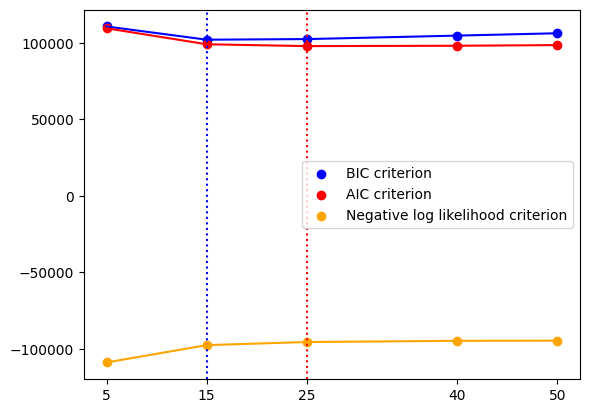

In [11]:
pca_col.show()

### `ZIPln`

The `ZiPln` model, a variant of the PLN model, is designed to handle zero
inflation in the data. It is defined as follows:

$$Y_{ij}\sim \mathcal W_{ij} \times  P(\exp(Z_{ij})), \quad \mathbf Z_i \sim \mathcal N(\mathbf o_i + \mathbf B ^{\top} \mathbf x_i, \mathbf \Sigma), \quad W_{ij} \sim \mathcal B(\sigma( \mathbf x_i^{0^{\top}}\mathbf B^0_j))$$

This model is particularly beneficial when the data contains a significant
number of zeros. It incorporates additional covariates for the zero inflation
coefficient, which are specified following the pipe `|` symbol in the formula, or via the `exog_inflation` keyword (see the [documentation](https://bbatardiere.pages.mia.inra.fr/pyplnmodels/zipln.html)). 


In [12]:
zi = ZIPln(counts)
zi.fit()
print(zi)

Setting the offsets to zero.
Fitting a ZIPln model with full covariance.
Intializing parameters ...
Initialization finished.


Upper bound on the fitting time: 100%|████████████████████████████| 400/400 [00:03<00:00, 116.94it/s]

Maximum number of iterations reached :  400 .
Last criterion =  5.4e-06 . Required tolerance = 1e-06
A multivariate ZIPln with full covariance.
     Loglike   Dimension    Nb param         BIC         AIC
   -96691.45         100        5250 112419.0476 101941.4531

* Useful properties/attributes
    .latent_variables .latent_positions .model_parameters .latent_parameters .optim_details
* Useful methods
    .transform() .show() .predict() .sigma() .projected_latent_variables() .plot_correlation_circle() .biplot() .viz() .pca_pairplot() .plot_expected_vs_true()
* Additional properties/properties for ZIPln are:
    .latent_prob
* Additional methods for ZIPln are:
    .viz_prob() .predict_prob_inflation() .pca_pairplot_prob()


# Visualization

A set of visualization methods is given to help the user interpret the outputs. The `viz` method performs PCA on the latent variables, while the `viz_positions` function
carries out PCA on the latent variables, adjusted for covariates. Additionally,
the `viz_prob` function provides a visual representation of the zero-inflation
probability.

#### Visualization with `Pln`

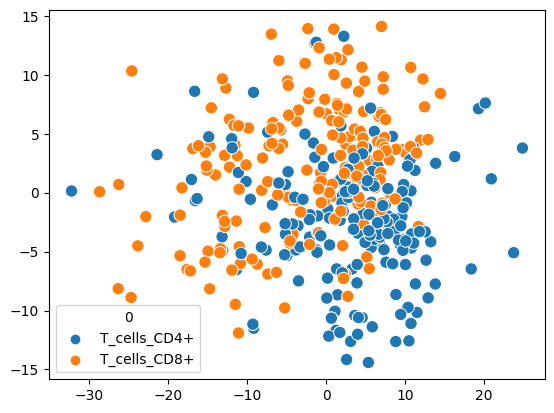

In [16]:
pln.viz(colors=labels)
plt.show()

### Visualization with `PlnPCA`

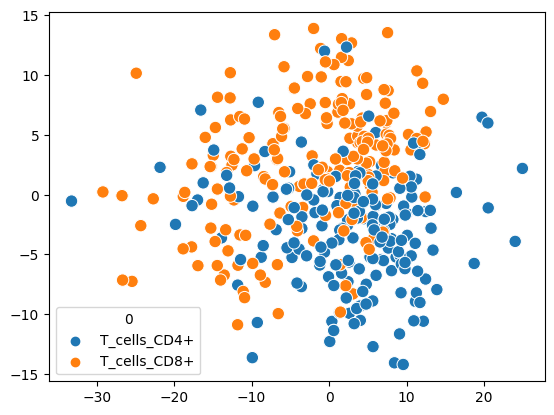

In [17]:
best_pca = pca_col.best_model()
best_pca.viz(colors = labels)
plt.show()

#### Visualization with `ZIPln`

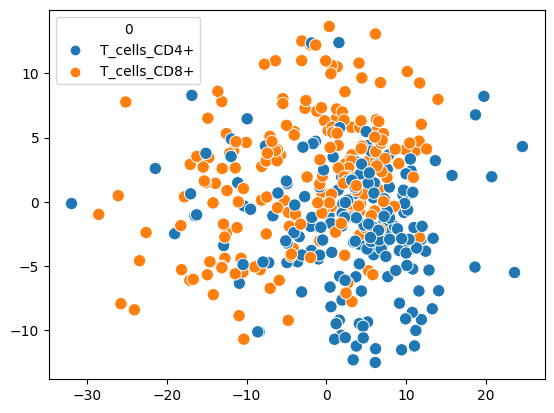

In [18]:
zi.viz(colors = labels)

### What would give a PCA on the log normalize data ? 

In [19]:
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns

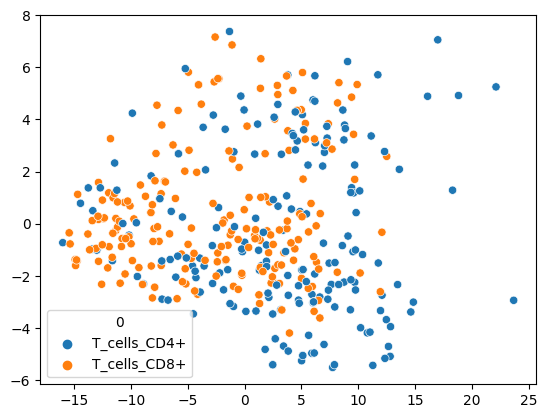

In [20]:
sk_pca = PCA(n_components = 2)
pca_log_counts = sk_pca.fit_transform(np.log(counts + (counts == 0)))
_ = sns.scatterplot(x = pca_log_counts[:,0], y = pca_log_counts[:,1], hue = labels)

### Visualization of the variables

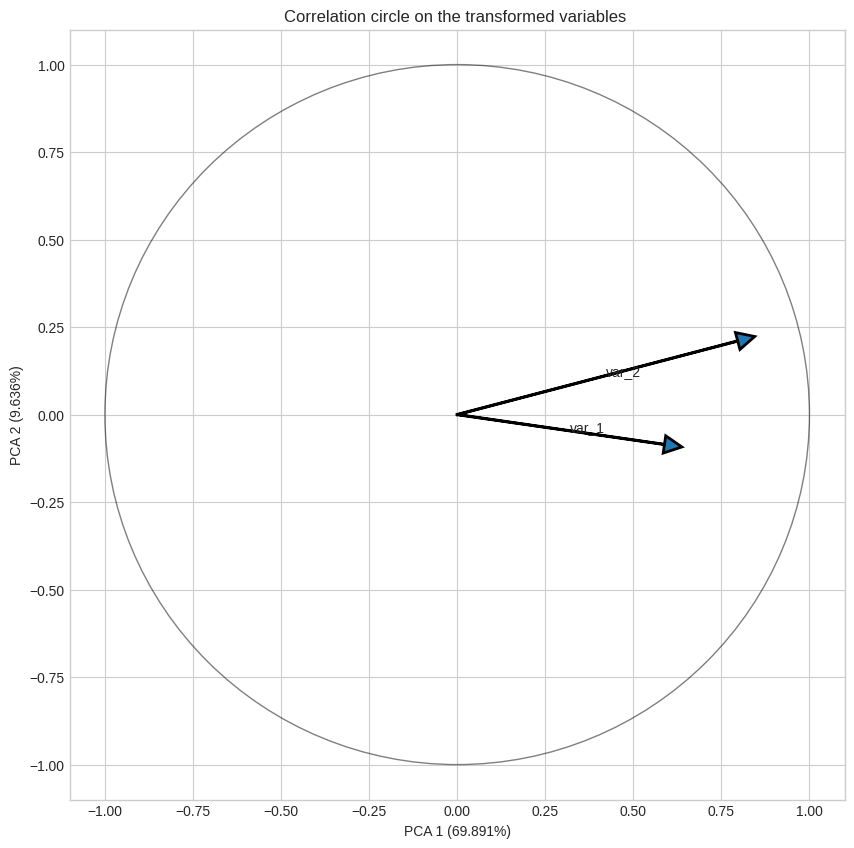

In [22]:
pln.plot_correlation_circle(["var_1","var_2"], indices_of_variables = [0,1])
plt.show()

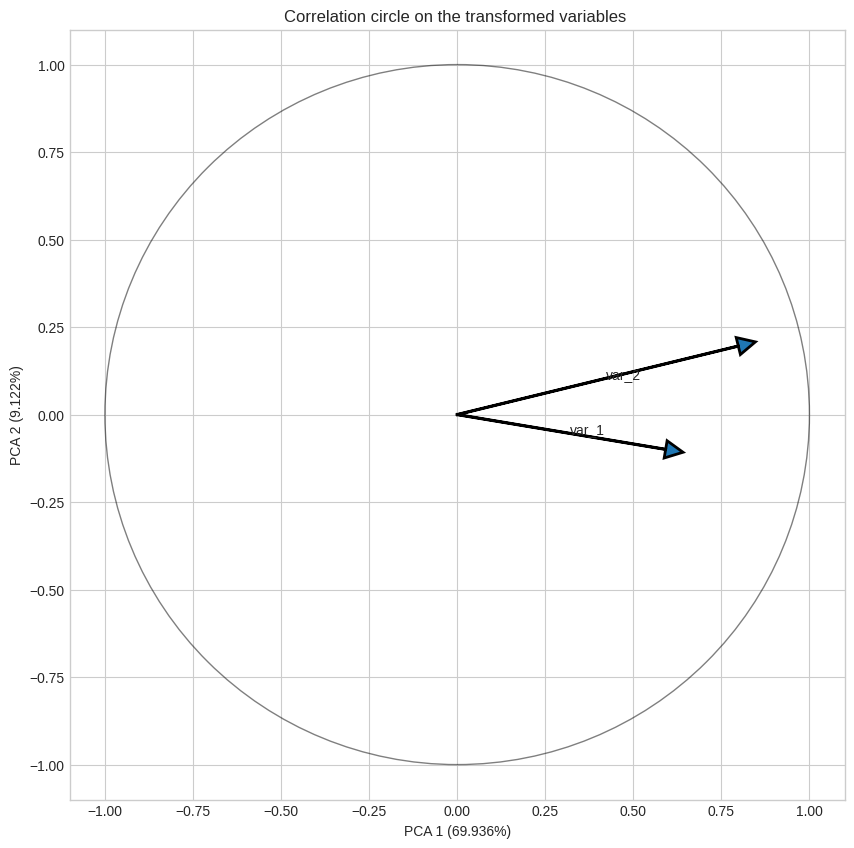

In [23]:
best_pca.plot_correlation_circle(["var_1","var_2"], indices_of_variables = [0,1])
plt.show()

### Visualization of each components of the PCA


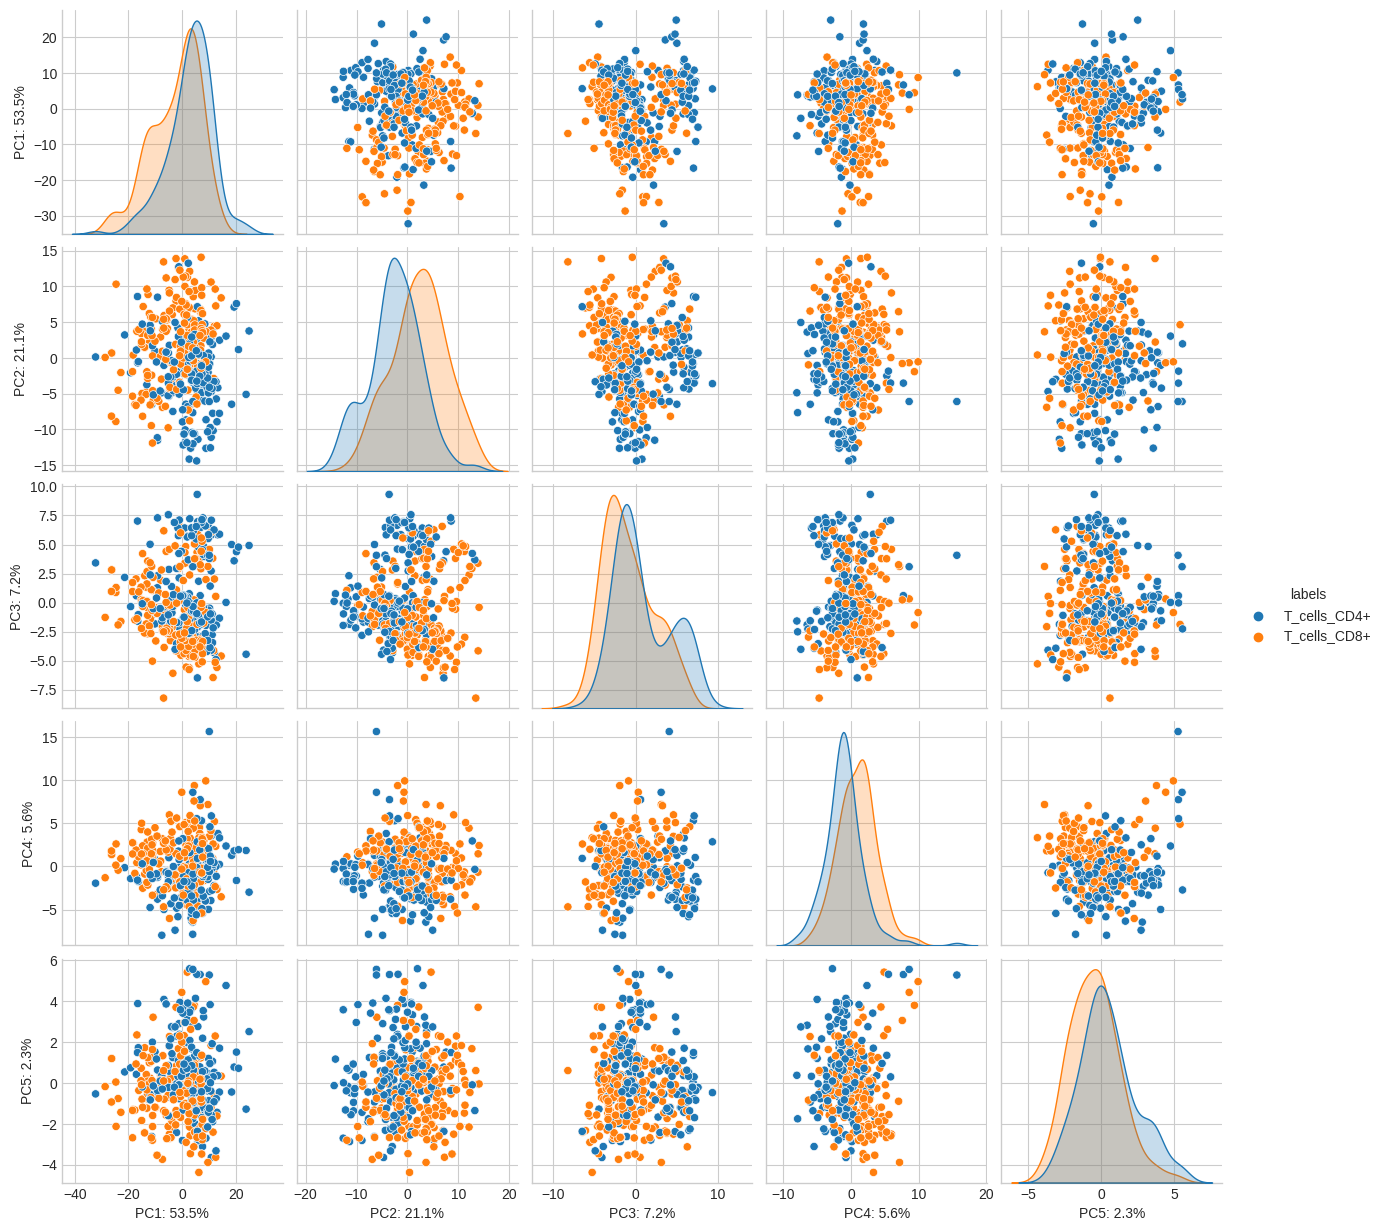

In [24]:
pln.pca_pairplot(colors = labels, n_components = 5)

# With covariates

### High benefits of zero-inflation
Some datasets are highly inflated (> 90% of zeros) and one need to take into account this zero-inflation. We load (a subsample of) the [microcosm](https://pubmed.ncbi.nlm.nih.gov/37308970/) dataset. In this dataset, three body
sites (for 45 cows) in addition to the milk of the 4 teats were sampled (vagina (V), milk (M),
Oral (O), Nasal (N)) at 4 times points: 1 week before calving (except for the milk), 1 month (1M),
3 months (3M) and 7 months (7M) after calving. 

We want to **remove the effect of the time in order to observe only the effect of the site**. We compare the `ZIPln` and the `Pln` models. Using the ZIPln model will remove the noise induced by the zero inflation.

In [53]:
data_mic = load_microcosm(n_samples =  500, dim =300)

In [54]:
print("Pourcentage of zeros: ", np.round(np.mean(np.mean(data_mic["endog"] == 0, axis = 0))*100), "%")

Pourcentage of zeros:  96.0 %


In [55]:
print(data_mic.keys())

dict_keys(['endog', 'site_1hot', 'site', 'lineage_1hot', 'lineage', 'time_1hot', 'time', 'affiliations'])


#### Classic Pln 

/home/bastien/These/redesign/pyplnmodels/pyPLNmodels/_data_handler.py:366: UserWarning: The (1) following (index) variables contain only zeros and are removed: [267].
  warnings.warn(


Setting the offsets to zero.
Now dataset of size torch.Size([500, 299]).
Fitting a Pln model with full covariance.
Intializing parameters ...
Initialization finished.



Upper bound on the fitting time: 100%|█████████████████████████████| 400/400 [00:04<00:00, 84.77it/s]


Maximum number of iterations reached :  400 .
Last criterion =  5.37e-06 . Required tolerance = 1e-06


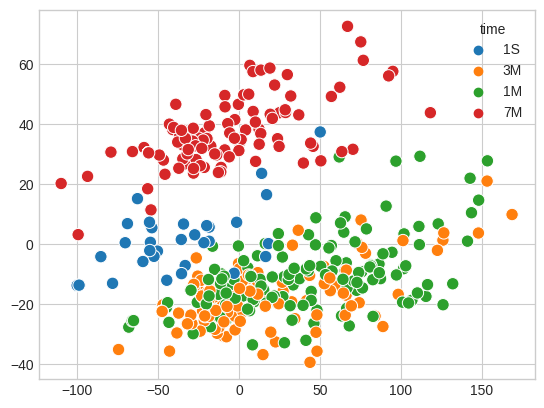

In [56]:
no_inflation = Pln.from_formula("endog ~ 1+time", data = data_mic)
no_inflation.fit()
no_inflation.viz(colors = data_mic["time"])

### With zero-inflation

`exog_inflation` and `exog` are set to the same array. If you need different `exog_inflation`, specify it with a pipe: '|' like in the following: endog ~ 1 + x | x + y 
Setting the offsets to zero.
Now dataset of size torch.Size([500, 299]).
Fitting a ZIPln model with full covariance.
Intializing parameters ...
Initialization finished.



Upper bound on the fitting time:  81%|███████████████████████▍     | 323/400 [00:09<00:02, 30.11it/s]


Upper bound on the fitting time: 100%|█████████████████████████████| 400/400 [00:12<00:00, 32.23it/s]


Maximum number of iterations reached :  400 .
Last criterion =  5.63e-06 . Required tolerance = 1e-06


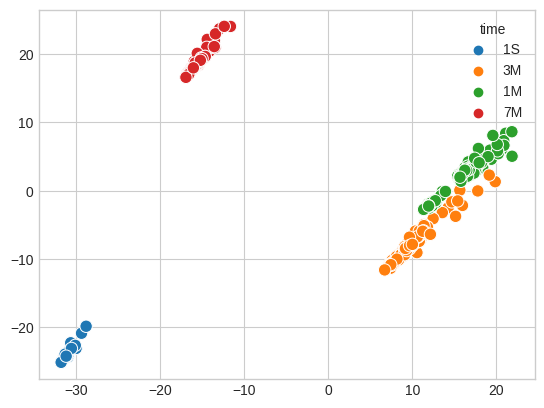

Upper bound on the fitting time:  56%|███████████████▊            | 565/1000 [00:31<00:08, 50.51it/s]

In [48]:
inflation = ZIPln.from_formula("endog ~ 1 + time", data = data_mic)
inflation.fit()
inflation.viz(colors = data_mic["time"])

The data is very well separated. We have to remove the effect of the time to see the effect of the site.

#### The `remove_exog_effect` removes the effect of covariates specified in the formula (time) when set to true in the `viz` method: 

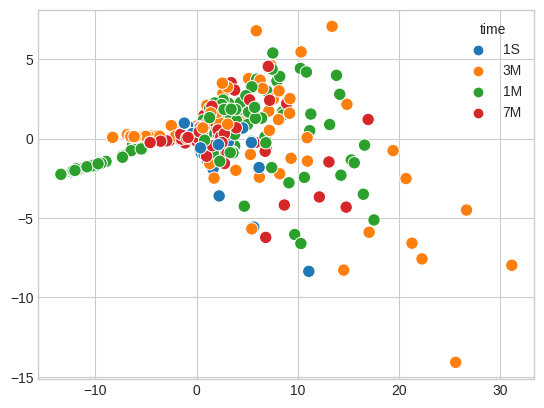

In [57]:
_ = inflation.viz(remove_exog_effect = True, colors = data_mic["time"])

#### However, the effect of the site is still present:

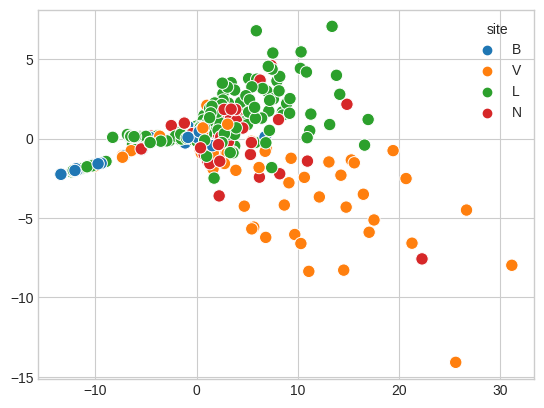

In [58]:
_ = inflation.viz(remove_exog_effect = True, colors = data_mic["site"])

The effect of the time is completely absent, but the effect of the site is present. If you want to extract those "not-site-dependent" positions, you can use the `latent_positions` attribute:


In [59]:
latent_pos = inflation.latent_positions

Specifiying "endog ~ 1 + site" in the formula, the `latent_positions` attribute would have contained the effect on the site only. 

#### One can also visualize the latent probabilites, but it is not often meaningful

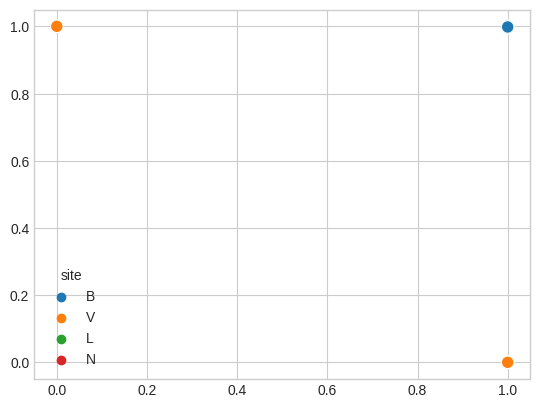

In [61]:
_ = inflation.viz_prob(colors = data_mic["site"])